In [4]:
from time import time
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scanpy as sc
from bbknn import bbknn
import scanorama as scnrma
import pandas as pd
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics.cluster import adjusted_rand_score


import warnings

warnings.filterwarnings('ignore')

sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.logging.print_memory_usage()

sc.set_figure_params(dpi=100, dpi_save=200)

scanpy==1.6.0 anndata==0.7.4 umap==0.3.10 numpy==1.17.2 scipy==1.5.2 pandas==1.1.0 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1 leidenalg==0.7.0
Memory usage: current 0.22 GB, difference +0.00 GB


In [5]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [6]:
def DE(adata, obs_id, obs_id_test, ref):

    sc.tl.rank_genes_groups(adata, groupby=obs_id, groups=[obs_id_test], 
                                reference=ref, method='wilcoxon', pts=True)

    lfcs = adata.uns['rank_genes_groups']['logfoldchanges'].astype([(obs_id_test, '<f8')]).view('<f8') 

    l231_genes = adata.uns['rank_genes_groups']['pts']

    lfcs = []
    names = list(adata.uns['rank_genes_groups']['names'].astype([(obs_id_test, '<U50')]).view('<U50'))
    logfoldchanges = adata.uns['rank_genes_groups']['logfoldchanges'].astype([(obs_id_test, '<f8')]).view('<f8')
    for i in l231_genes.index:
        lfcs.append(logfoldchanges[names.index(i)])

    l231_genes['LF'] = lfcs

    #plt.hist(l231_genes[obs_id_test].values)

    l231_genes = l231_genes[l231_genes[obs_id_test]>0.2]

    return pd.Series(l231_genes['LF']).sort_values(ascending=False)

# Meis2 UMAPs

In [10]:

gaba_all = sc.read_h5ad(path + 'gaba_all_for_Meis2_separation.h5ad')

In [ ]:
#sc.pl.umap(gaba_all, color='Age', save='GABA+Meis2_age.pdf')
#sc.pl.umap(gaba_all, color=['Pax6'], vmax=2.5,save='GABA+Pax6_feature.pdf')

# Tracksplot

In [7]:

processed_objs = []
ages = ['P8', 'P14', 'P17', 'P21', 'P28', 'P38']

for i in range(len(ages)):
    processed_objs.append(sc.read_h5ad(path_in + ages[i] + '_gaba_March.h5ad'))

In [8]:
gaba_all = processed_objs[0].concatenate(processed_objs[1:])

In [9]:
gaba_all.obs['Subclass'] = gaba_all.obs['Subclass'].cat.reorder_categories(['Pvalb', 'Sst', 'Vip', 'Lamp5', 'Stac', 'Frem1'], ordered=True)

... storing 'leiden' as categorical
... storing 'sample' as categorical
... storing 'Age' as categorical
... storing 'Type' as categorical


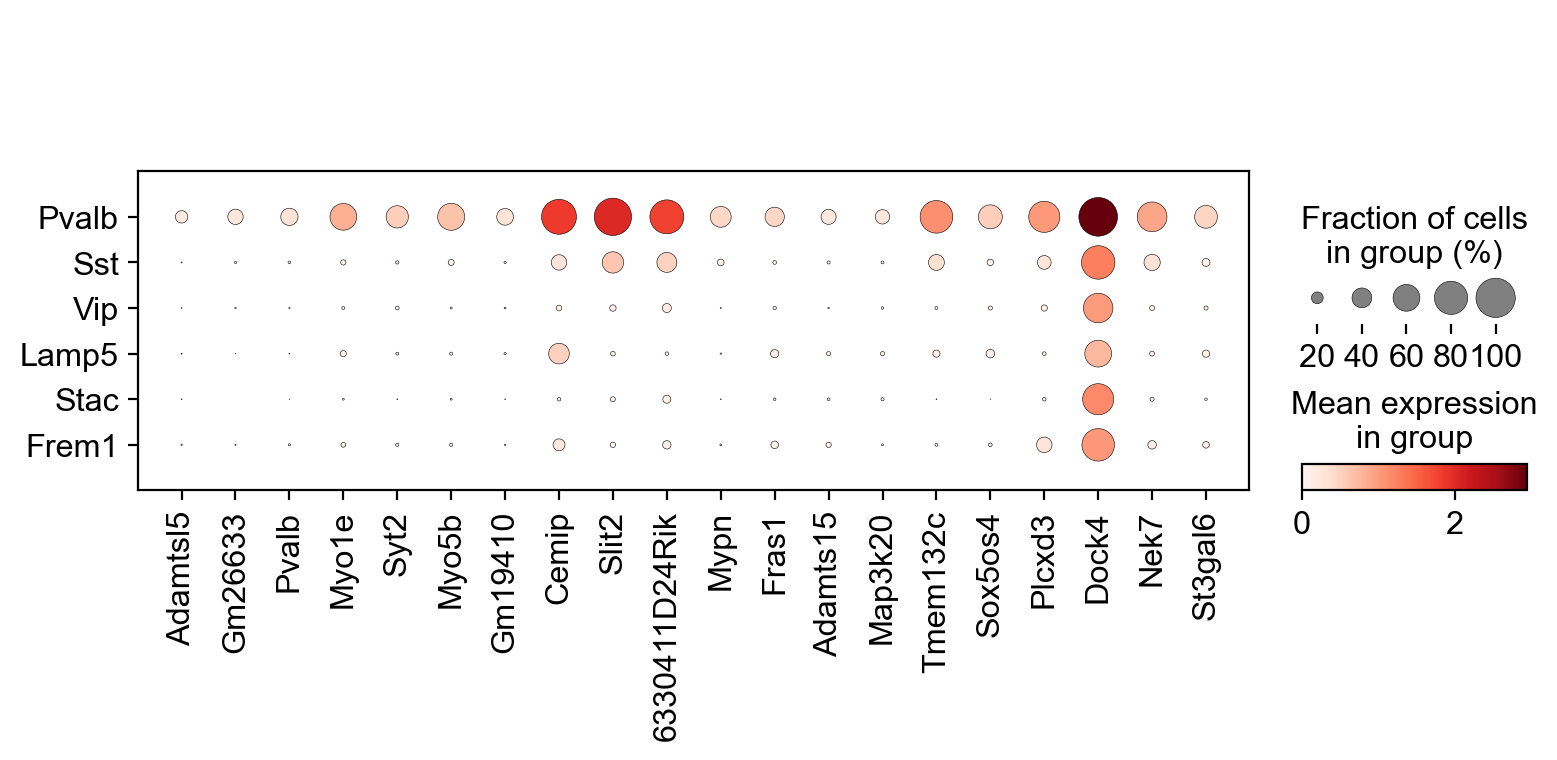

Index(['Adamtsl5', 'Gm26633', 'Pvalb', 'Myo1e', 'Syt2', 'Myo5b', 'Gm19410',
       'Cemip', 'Slit2', '6330411D24Rik', 'Mypn', 'Fras1', 'Adamts15',
       'Map3k20', 'Tmem132c', 'Sox5os4', 'Plcxd3', 'Dock4', 'Nek7', 'St3gal6'],
      dtype='object')


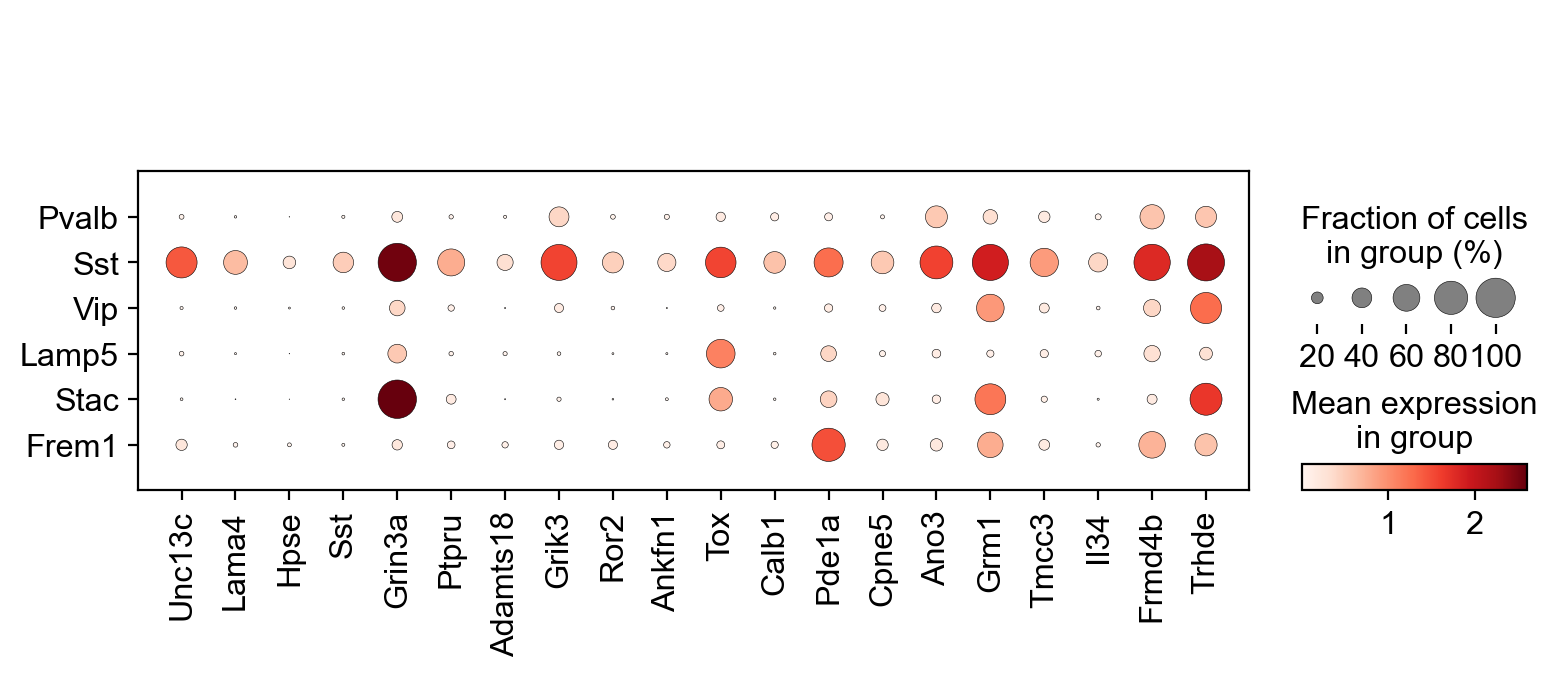

Index(['Unc13c', 'Lama4', 'Hpse', 'Sst', 'Grin3a', 'Ptpru', 'Adamts18',
       'Grik3', 'Ror2', 'Ankfn1', 'Tox', 'Calb1', 'Pde1a', 'Cpne5', 'Ano3',
       'Grm1', 'Tmcc3', 'Il34', 'Frmd4b', 'Trhde'],
      dtype='object')


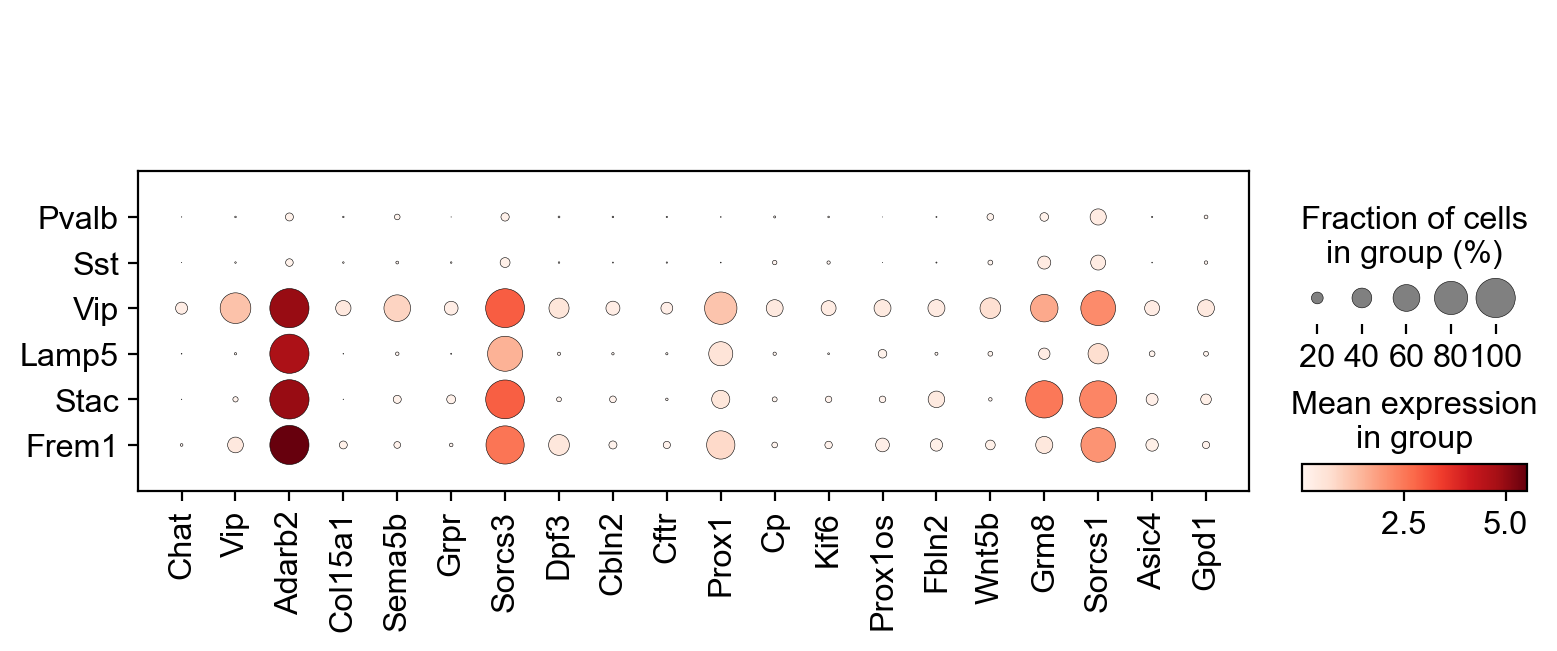

Index(['Chat', 'Vip', 'Adarb2', 'Col15a1', 'Sema5b', 'Grpr', 'Sorcs3', 'Dpf3',
       'Cbln2', 'Cftr', 'Prox1', 'Cp', 'Kif6', 'Prox1os', 'Fbln2', 'Wnt5b',
       'Grm8', 'Sorcs1', 'Asic4', 'Gpd1'],
      dtype='object')


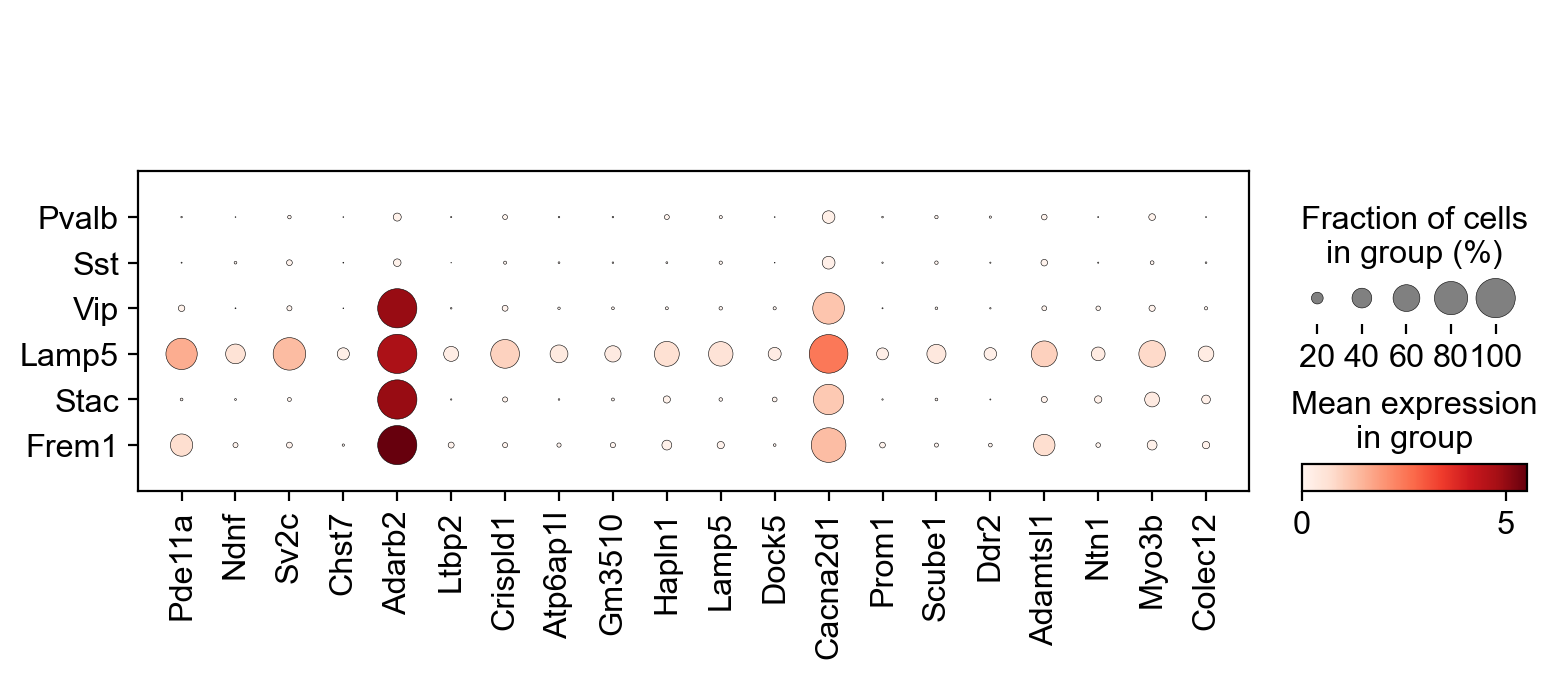

Index(['Pde11a', 'Ndnf', 'Sv2c', 'Chst7', 'Adarb2', 'Ltbp2', 'Crispld1',
       'Atp6ap1l', 'Gm3510', 'Hapln1', 'Lamp5', 'Dock5', 'Cacna2d1', 'Prom1',
       'Scube1', 'Ddr2', 'Adamtsl1', 'Ntn1', 'Myo3b', 'Colec12'],
      dtype='object')


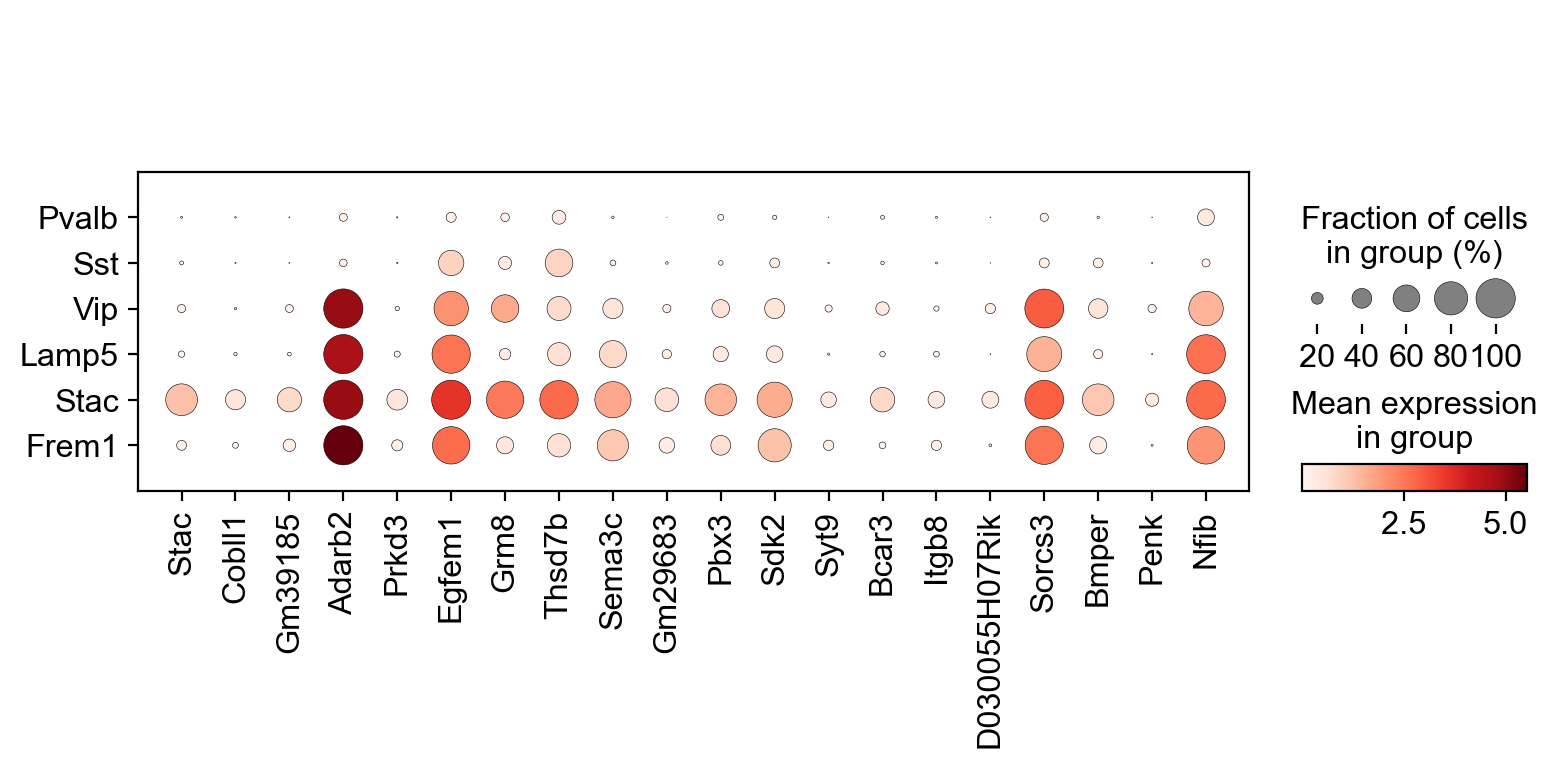

Index(['Stac', 'Cobll1', 'Gm39185', 'Adarb2', 'Prkd3', 'Egfem1', 'Grm8',
       'Thsd7b', 'Sema3c', 'Gm29683', 'Pbx3', 'Sdk2', 'Syt9', 'Bcar3', 'Itgb8',
       'D030055H07Rik', 'Sorcs3', 'Bmper', 'Penk', 'Nfib'],
      dtype='object')


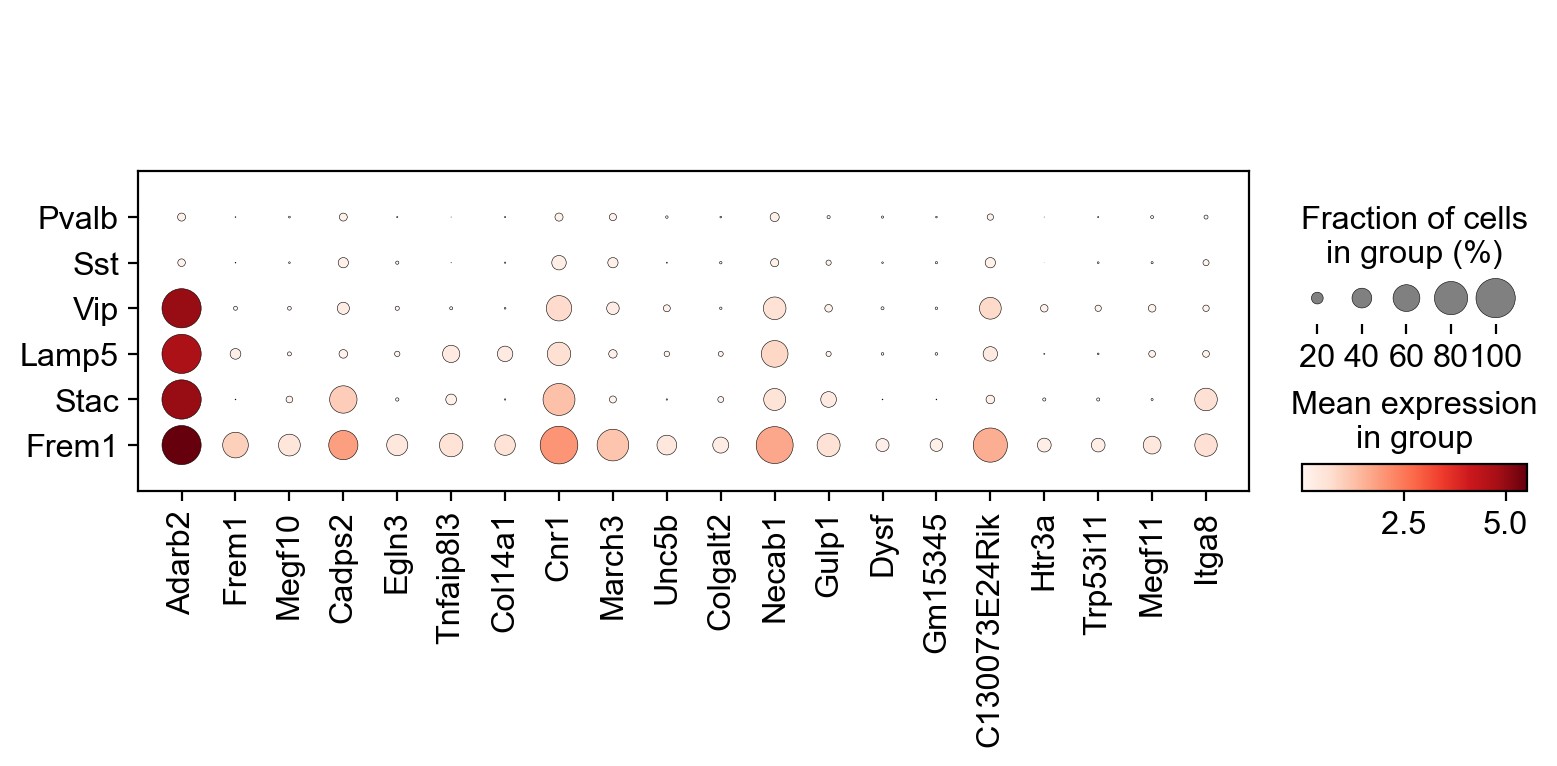

Index(['Adarb2', 'Frem1', 'Megf10', 'Cadps2', 'Egln3', 'Tnfaip8l3', 'Col14a1',
       'Cnr1', 'March3', 'Unc5b', 'Colgalt2', 'Necab1', 'Gulp1', 'Dysf',
       'Gm15345', 'C130073E24Rik', 'Htr3a', 'Trp53i11', 'Megf11', 'Itga8'],
      dtype='object')


In [38]:
for i in gaba_all.obs.Subclass.values.categories:

    de_genes = DE(gaba_all, obs_id='Subclass', obs_id_test=i, ref='rest').index
    
    sc.pl.dotplot(gaba_all, de_genes[0:20], groupby='Subclass')
    print(de_genes[0:20])

In [40]:
gaba_all.obs.Subclass.value_counts()

Pvalb    5020
Sst      3751
Vip      2304
Lamp5    1520
Frem1     431
Stac      348
Name: Subclass, dtype: int64

In [17]:
subs = []
for i in gaba_all.obs.Subclass.values.categories:
    sub = gaba_all[gaba_all.obs.Subclass==i,:]
    
    if (sub.shape[0]>1000):
        sc.pp.subsample(sub, n_obs=1000)
        subs.append(sub)
        
    else:
        sc.pp.subsample(sub, n_obs=348)
        subs.append(sub)
    
adata_subs = subs[0].concatenate(subs[1:])

In [42]:
adata_subs.write_h5ad('gaba_subclasses_subsampled.h5ad')

... storing 'leiden' as categorical
... storing 'Subclass' as categorical
... storing 'Type' as categorical


In [19]:
adata_subs = sc.read_h5ad('gaba_subclasses_subsampled.h5ad')

In [20]:
adata_subs.obs['Subclass'] = adata_subs.obs['Subclass'].cat.reorder_categories(['Pvalb', 'Sst', 'Vip', 'Lamp5', 'Stac', 'Frem1'], ordered=True)

In [21]:
adata_subs.uns['Subclass_colors'] = sns.color_palette('pastel').as_hex()[0:6]

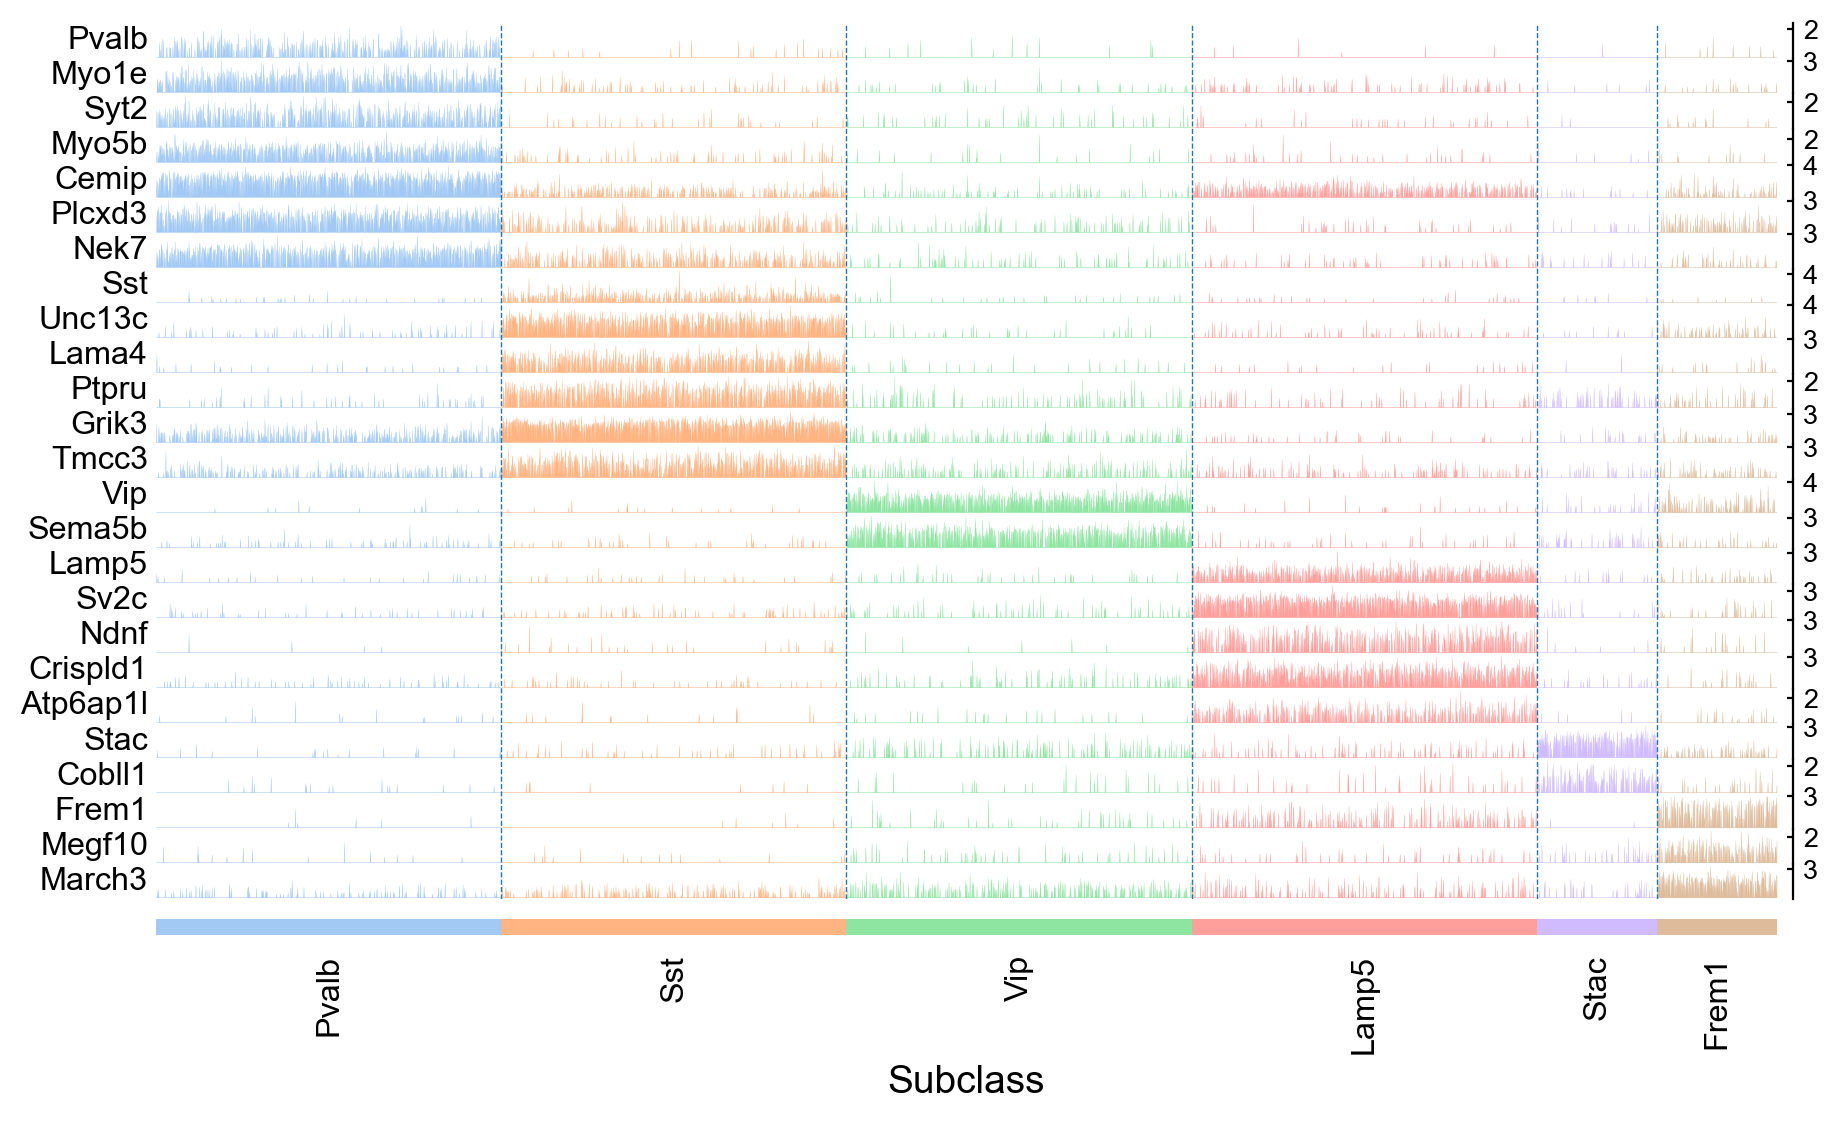

In [24]:
hm_markers = ['Pvalb', 'Myo1e', 'Syt2', 'Myo5b', 'Cemip', 'Plcxd3', 'Nek7',
              'Sst', 'Unc13c', 'Lama4', 'Ptpru', 'Grik3', 'Tmcc3', 
              'Vip', 'Sema5b', 
              'Lamp5', 'Sv2c', 'Ndnf', 'Crispld1', 'Atp6ap1l', 
              'Stac', 'Cobll1', 
              'Frem1', 'Megf10', 'March3']
sc.pl.tracksplot(shuffle(adata_subs), hm_markers, groupby='Subclass',
                 figsize=(11, 6), save='GABA_tracksplot.pdf')

# Relative frequency of subclass

Across all other cells

In [183]:
sns.color_palette('pastel').as_hex()[0:6]

['#a1c9f4', '#ffb482', '#8de5a1', '#ff9f9b', '#d0bbff', '#debb9b']

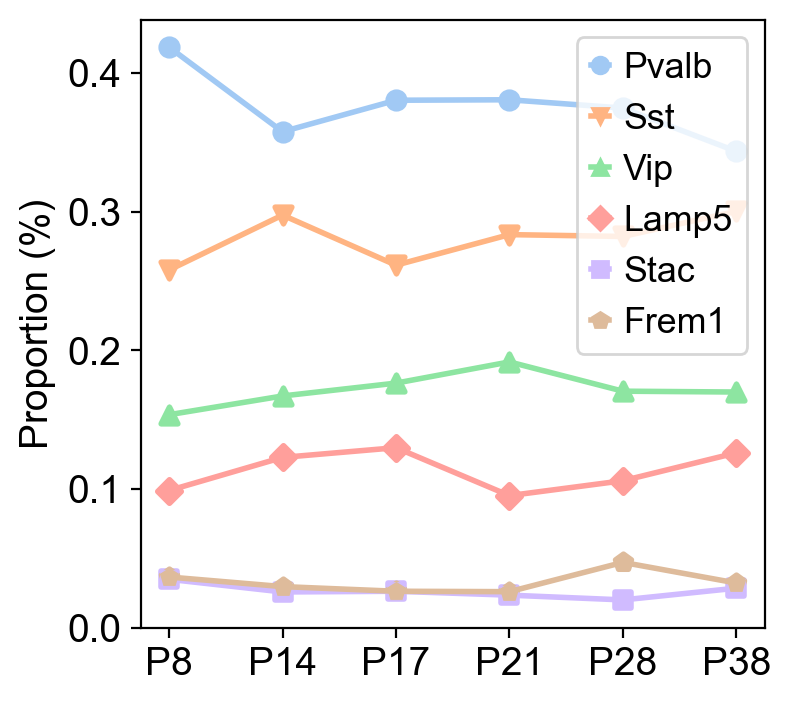

In [16]:
palette = sns.color_palette('pastel').as_hex()[0:6]
marker = ['o', 'v', '^', 'D', 's', 'p', '*']
ages = gaba_all.obs.Age.values.categories

idx = 0
for i in gaba_all.obs.Subclass.values.categories:
    fracs = []
    for age in ages:
        age_obj = gaba_all[gaba_all.obs.Age==age,:]

        fracs.append(age_obj.obs.Subclass.value_counts(normalize=True)[i])
    plt.scatter(ages, fracs, marker=marker[idx], color=palette[idx],
               linewidths=2,)
    plt.plot(ages, fracs, marker=marker[idx], color=palette[idx], linewidth=2, label=i)
    idx = idx + 1
    plt.legend()

plt.ylabel('Proportion (%)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks([0,0.1,0.2,0.3,0.4],fontsize=14)
plt.grid(False)

plt.savefig('figures/GABA_subclass_freqs.pdf')


# Type UMAPs

In [66]:
cols = sns.color_palette('pastel').as_hex() + sns.color_palette('Set2').as_hex()[0:5]

In [67]:
len(cols)

15

No Lamp5 types.

In [61]:
pd.Categorical(gaba_all.obs.Type.values).value_counts()

Frem1       431
Lamp5       630
Lamp5_A     514
Lamp5_B     376
Pvalb_A    1620
Pvalb_B    1420
Pvalb_C    1070
Pvalb_D     910
Sst_A      1171
Sst_B       789
Sst_C       843
Sst_D       559
Sst_E       389
Stac        348
Vip_A       919
Vip_B       861
Vip_C       524
dtype: int64

## Rename Lamp5 types

In [63]:
gaba_types = []

for i in gaba_all.obs.Type:
    if (i in ['Lamp5_A', 'Lamp5_B']): 
        gaba_types.append('Lamp5')
    else: gaba_types.append(i)
        

In [65]:
pd.Categorical(gaba_types).value_counts()

Frem1       431
Lamp5      1520
Pvalb_A    1620
Pvalb_B    1420
Pvalb_C    1070
Pvalb_D     910
Sst_A      1171
Sst_B       789
Sst_C       843
Sst_D       559
Sst_E       389
Stac        348
Vip_A       919
Vip_B       861
Vip_C       524
dtype: int64

In [68]:
gaba_all.obs['Type'] = pd.Categorical(gaba_types)

In [70]:
gaba_all.uns['Type_colors'] = cols

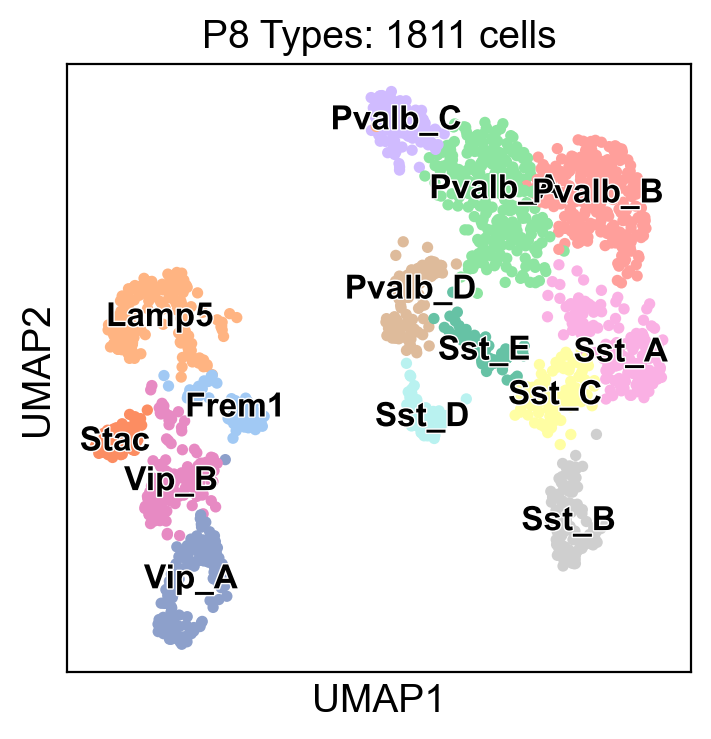

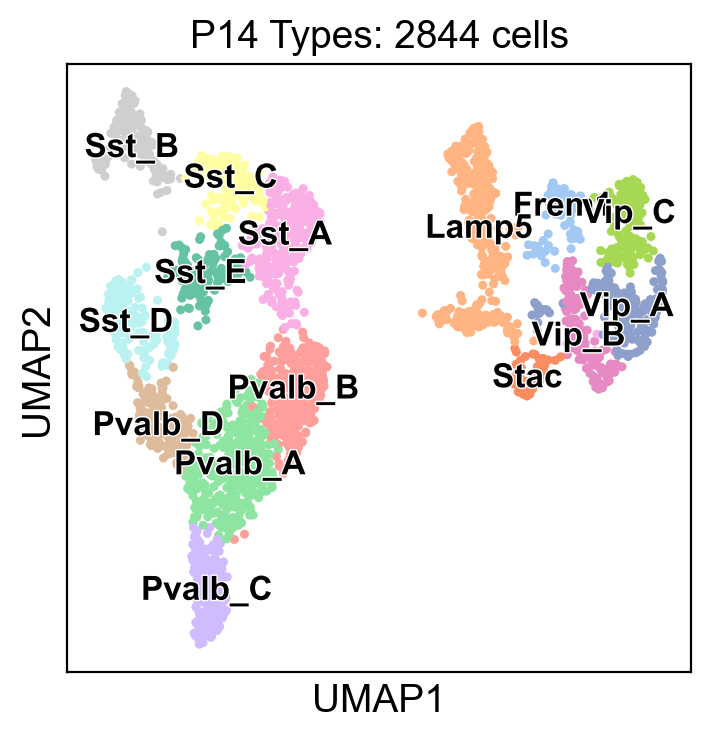

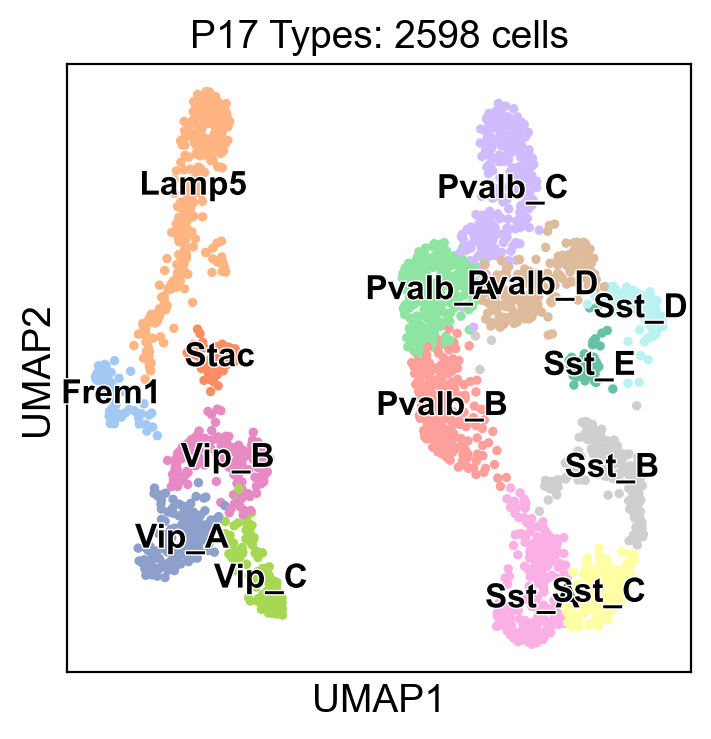

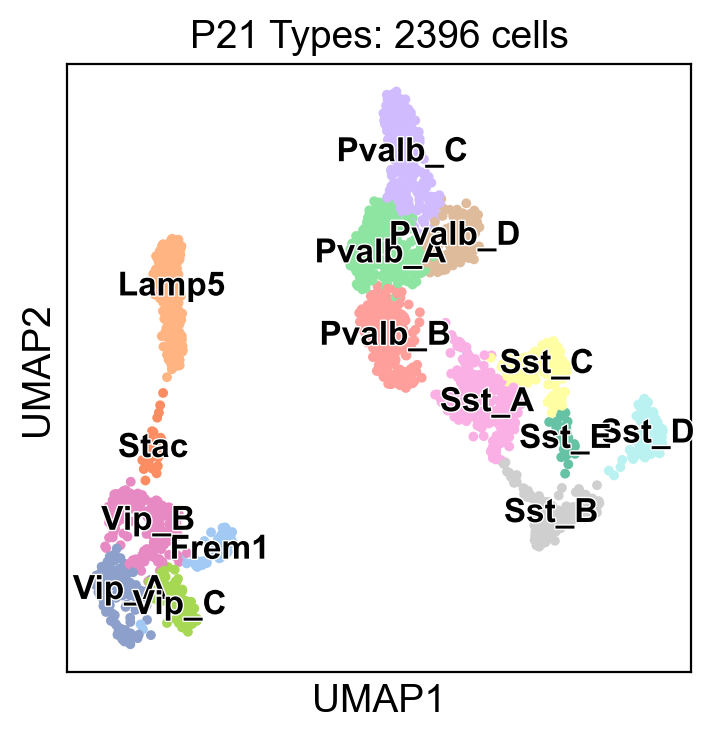

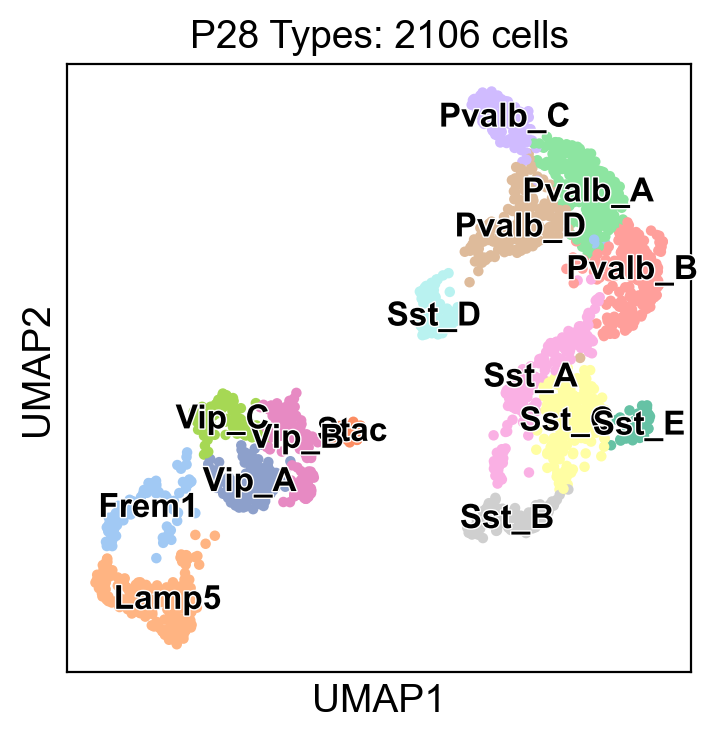

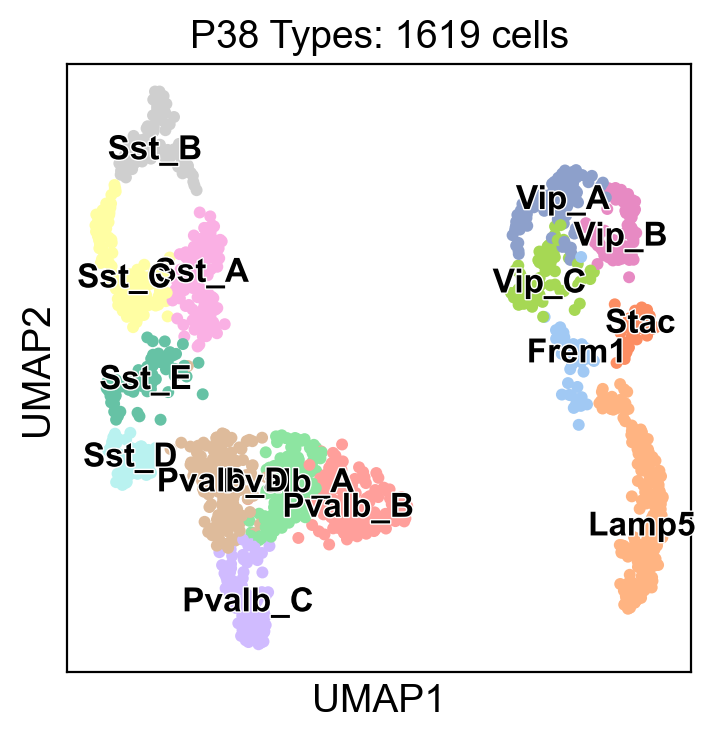

In [73]:
for i in gaba_all.obs.Age.values.categories:

    age = gaba_all[gaba_all.obs.Age==i,:]
    sc.pl.umap(age, color='Type', legend_loc='on data', legend_fontsize='12',  title=i+' Types: ' + str(age.shape[0]) + ' cells', 
           legend_fontoutline=1, save=i+'gaba.pdf')

In [75]:
gaba_all.write_h5ad('gaba_full_051921.h5ad')

In [78]:
for i in gaba_all.obs.Age.values.categories:

    gaba_all[gaba_all.obs.Age==i,:].write_h5ad(path_out + i + '_gaba_March.h5ad')

# Relative frequency of types
Within a subclass

## Pvalb

In [7]:
pv = gaba_all[gaba_all.obs.Subclass=='Pvalb',:]

In [19]:
ages = pv.obs.Age.values.categories
types = pv.obs.Type.values.categories
freqs_pv = [[],[],[],[]] 

f = 0
for i in types:
    for j in ages:
        age = pv[pv.obs.Age==j,:]
        age_freqs = age.obs.Type.value_counts(normalize=True)
        freqs_pv[f].append(age_freqs[i])
        
    f = f + 1

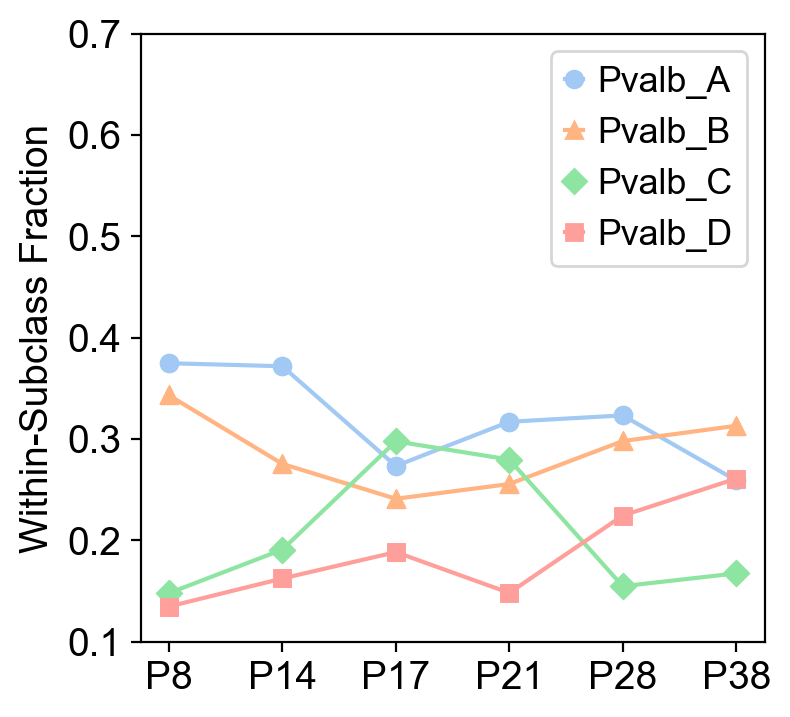

In [30]:
markers = ['o', '^', 'D', 's', '8', 'p']
palette = sns.color_palette('pastel').as_hex()

for count, type_ in enumerate(types):
    plt.scatter(ages, freqs_pv[count], marker = markers[count], color=palette[count])
    plt.plot(ages, freqs_pv[count], label=type_, marker = markers[count], color=palette[count])
    
#plt.legend(bbox_to_anchor=(1, 1))
plt.legend()
plt.ylim([0.1,0.7])
plt.ylabel('Within-Subclass Fraction')
plt.grid(False)
plt.savefig('PV_type_freqs.pdf')

## Sst

In [37]:
sst = gaba_all[gaba_all.obs.Subclass=='Sst',:]

sc.pl.dotplot(sst, 'Gad1', groupby='Type')

In [40]:
ages = sst.obs.Age.values.categories
types = sst.obs.Type.values.categories
freqs_sst = [[],[],[],[],[]] 

f = 0
for i in types:
    for j in ages:
        age = sst[sst.obs.Age==j,:]
        age_freqs = age.obs.Type.value_counts(normalize=True)
        freqs_sst[f].append(age_freqs[i])
        
    f = f + 1

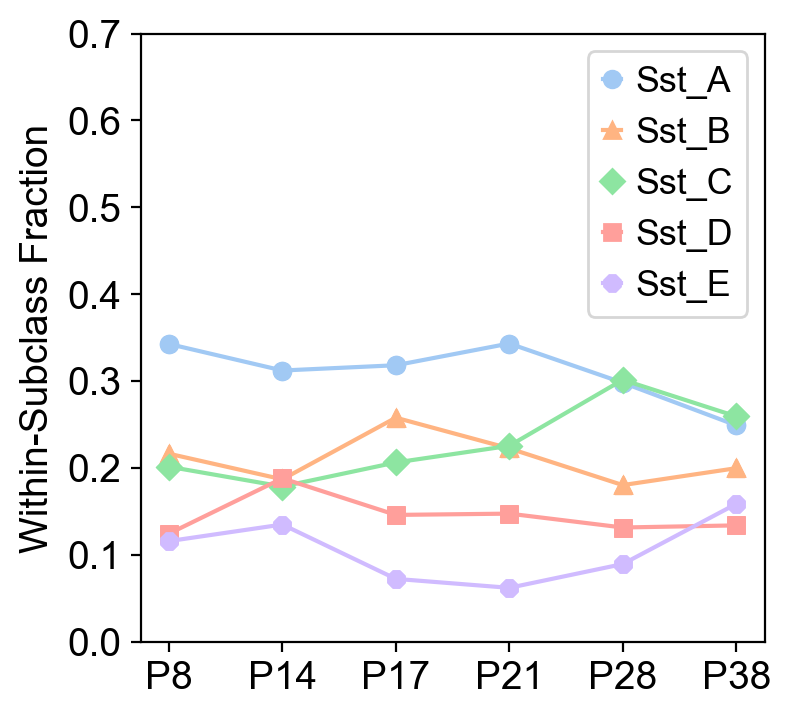

In [43]:
markers = ['o', '^', 'D', 's', '8', 'p']
palette = sns.color_palette('pastel').as_hex()

for count, type_ in enumerate(types):
    plt.scatter(ages, freqs_sst[count], marker = markers[count], color=palette[count])
    plt.plot(ages, freqs_sst[count], label=type_, marker = markers[count], color=palette[count])
    
#plt.legend(bbox_to_anchor=(1, 1))
plt.legend()
plt.ylim([0,0.7])
plt.ylabel('Within-Subclass Fraction')
plt.grid(False)
plt.savefig('sst_type_freqs.pdf')

## Vip

In [44]:
vip = gaba_all[gaba_all.obs.Subclass=='Vip',:]

Vip_C at P8: get value from mapping dot plot in Drive. It's about half of Vip_A.

In [54]:
vip[vip.obs.Age=='P8'].obs.Type.value_counts(normalize=True)

Vip_A    0.521583
Vip_B    0.478417
Name: Type, dtype: float64

In [66]:
ages = vip.obs.Age.values.categories
types = vip.obs.Type.values.categories
freqs_vip = [[],[],[]]

f = 0
for i in types:
    for j in ages:
        
        if (j=='P8'):
            if (i=='Vip_C'):
                #age = vip[vip.obs.Age==j,:]
                #age_freqs = age.obs.Type.value_counts(normalize=True)
                freqs_vip[f].append(0.30)
                
            elif (i=='Vip_A'):
                #age = vip[vip.obs.Age==j,:]
                #age_freqs = age.obs.Type.value_counts(normalize=True)
                freqs_vip[f].append(0.5215827338129496-0.30)
                
            else: 
                age = vip[vip.obs.Age==j,:]
                age_freqs = age.obs.Type.value_counts(normalize=True)
                freqs_vip[f].append(age_freqs[i])
            
        
        else:
            age = vip[vip.obs.Age==j,:]
            age_freqs = age.obs.Type.value_counts(normalize=True)
            freqs_vip[f].append(age_freqs[i])
        
    f = f + 1

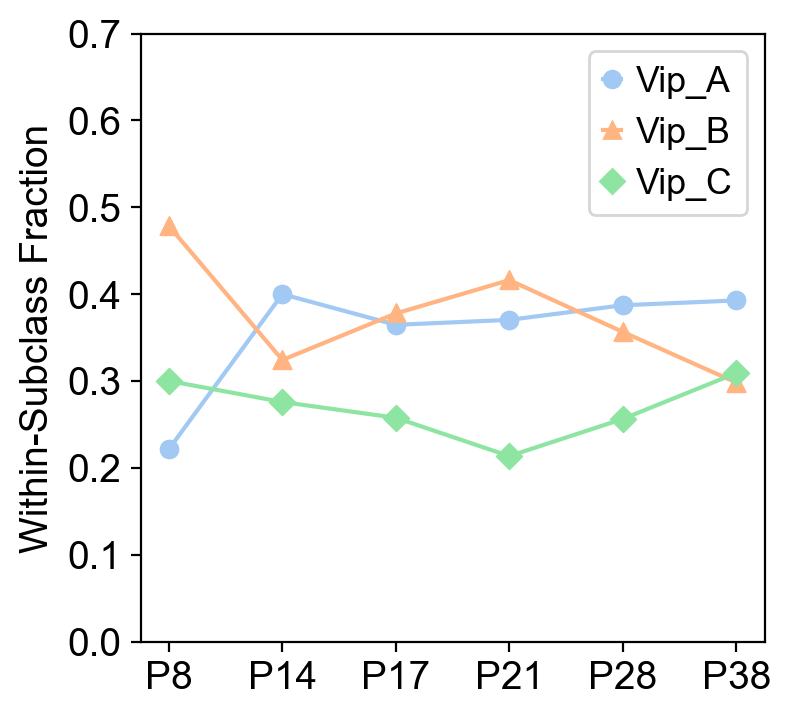

In [67]:
markers = ['o', '^', 'D', 's', '8', 'p']
palette = sns.color_palette('pastel').as_hex()

for count, type_ in enumerate(types):
    plt.scatter(ages, freqs_vip[count], marker = markers[count], color=palette[count])
    plt.plot(ages, freqs_vip[count], label=type_, marker = markers[count], color=palette[count])
    
#plt.legend(bbox_to_anchor=(1, 1))
plt.legend()
plt.ylim([0,0.7])
plt.ylabel('Within-Subclass Fraction')
plt.grid(False)
plt.savefig('vip_type_freqs.pdf')

## Others

In [71]:
others = gaba_all[gaba_all.obs.Subclass!='Pvalb']
others = others[others.obs.Subclass!='Sst']
others = others[others.obs.Subclass!='Vip']

sc.pl.dotplot(others, 'Gad1', groupby='Type')

In [73]:
ages = others.obs.Age.values.categories
types = others.obs.Type.values.categories
freqs_others = [[],[],[],[],[]] 

f = 0
for i in types:
    for j in ages:
        age = others[others.obs.Age==j,:]
        age_freqs = age.obs.Type.value_counts(normalize=True)
        freqs_others[f].append(age_freqs[i])
        
    f = f + 1

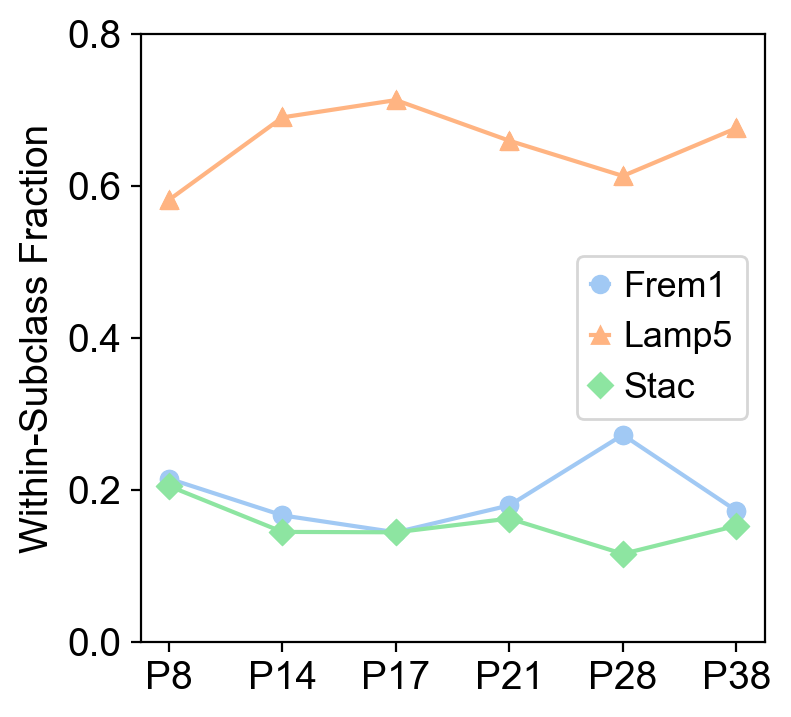

In [75]:
markers = ['o', '^', 'D', 's', '8', 'p']
palette = sns.color_palette('pastel').as_hex()

for count, type_ in enumerate(types):
    plt.scatter(ages, freqs_others[count], marker = markers[count], color=palette[count])
    plt.plot(ages, freqs_others[count], label=type_, marker = markers[count], color=palette[count])
    
#plt.legend(bbox_to_anchor=(1, 1))
plt.legend()
plt.ylim([0,0.8])
plt.ylabel('Within-Subclass Fraction')
plt.grid(False)
plt.savefig('others_type_freqs.pdf')

# Type Marker Plots

In [18]:
gaba_all[gaba_all.obs.Subclass=='Pvalb',:].obs.Type

TCAATCTAGAGCAGAA-1-P8_2a-P8-P8-0       Pvalb_D
CGGTCAGTCTCTTCAA-1-P8_2a-P8-P8-0       Pvalb_B
ATGTCTTTCGCTCCTA-1-P8_2a-P8-P8-0       Pvalb_A
GAAGCCCTCCTACCAC-1-P8_1b-P8-P8-0       Pvalb_D
ATGCCTCTCTAGCCAA-1-P8_2b-P8-P8-0       Pvalb_A
                                        ...   
GCTTCACTCACCCTTG-1-P38_1a-P38-P38-5    Pvalb_D
TGTGATGGTCACTCGG-1-P38_2b-P38-P38-5    Pvalb_D
ATCCCTGTCCAGTTCC-1-P38_2b-P38-P38-5    Pvalb_D
TCGGGCAGTGGTAATA-1-P38_1a-P38-P38-5    Pvalb_B
GTATTTCCAGGCTCTG-1-P38_1a-P38-P38-5    Pvalb_C
Name: Type, Length: 5020, dtype: object

In [11]:
pv = gaba_all[gaba_all.obs.Subclass=='Pvalb',:]

In [21]:
for i in ['Pvalb_A', 'Pvalb_B', 'Pvalb_C', 'Pvalb_D']:
    print(DE(adata=pv, obs_id='Type', 
             obs_id_test = i, ref='rest')[0:10].index)

Trying to set attribute `.obs` of view, copying.
... storing 'leiden' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Age' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Type' as categorical


Index(['Reln', 'Ap1s3', 'Sgcz', 'Cntn5', 'Cdk6', 'Pdzrn3', 'Olfm3', 'Cdh20',
       'Sphkap', 'Grb14'],
      dtype='object')
Index(['Col25a1', 'Il1rapl2', 'Ndst4', 'Thsd7a', 'Inpp4b', 'Cdh4', 'Ncam2',
       'Fat4', 'Nkain3', 'Zbtb20'],
      dtype='object')
Index(['Gpr149', 'Prss12', 'Htr2c', 'March1', 'Chrm2', 'Zfpm2', 'Grm1',
       'Adra1b', 'Dscam', 'Fam163a'],
      dtype='object')
Index(['Gm32647', 'Slc39a8', 'Ralyl', 'Spon1', 'Brinp3', 'Rspo2', 'Cnih3',
       'Sema3e', 'Gm43670', 'Gm19202'],
      dtype='object')


In [6]:
from matplotlib.colors import ListedColormap
mapcol = ListedColormap(sns.color_palette('light:#a31fe7', n_colors=100).as_hex())

Trying to set attribute `.obs` of view, copying.
... storing 'leiden' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Age' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Type' as categorical


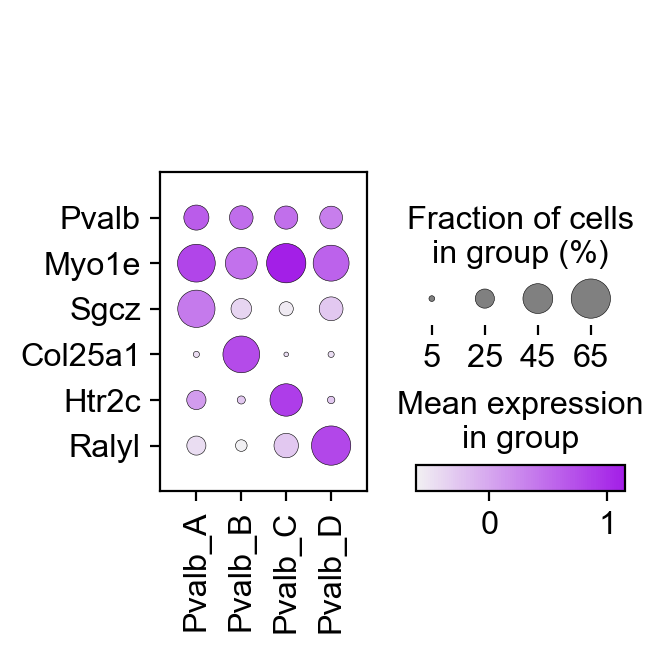

In [12]:
sc.pl.dotplot(pv, ['Pvalb', 'Myo1e',
                   'Sgcz', 
                    'Col25a1', 
                   'Htr2c', 
                    'Ralyl'], 
              groupby='Type',swap_axes=True, use_raw=False, dot_min=0,dot_max=0.65,
              cmap=mapcol,
              save='PV_type_markersS6.pdf')

In [13]:
sst = gaba_all[gaba_all.obs.Subclass=='Sst',:]

In [31]:
for i in ['Sst_A', 'Sst_B', 'Sst_C', 'Sst_D', 'Sst_E']:
    print(DE(adata=sst, obs_id='Type', 
             obs_id_test = i, ref='rest')[0:10].index)

Trying to set attribute `.obs` of view, copying.
... storing 'leiden' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Age' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Type' as categorical


Index(['Pcsk5', 'Col25a1', 'Inpp4b', 'Mrap2', 'Zbtb20', 'Thsd7a', 'Gm21949',
       'Kirrel3', 'Ajap1', 'Fstl4'],
      dtype='object')
Index(['Il1rapl2', 'B130024G19Rik', 'Plpp4', 'Nr2f2', 'Kit', 'Pld5', 'Cdh12',
       'Zmat4', 'Pcsk6', 'Tmem132e'],
      dtype='object')
Index(['Hpse', 'Syt6', 'Pdyn', 'Prdm1', 'Kcnq4', 'Clstn2', 'Zfp804a', 'Tox',
       'Col11a1', 'Rerg'],
      dtype='object')
Index(['Sgpp2', 'Kcnip4', 'Rxfp1', 'Pla2g4a', 'Antxr2', 'Lrp1b', 'Ptprk',
       'Bcl6', 'Gm43670', 'Npr3'],
      dtype='object')
Index(['Crhr2', 'Grm8', 'Col6a1', 'Hcrtr2', 'Unc5d', 'Alk', 'Gm32647', 'Dcc',
       'Ltbp1', 'Trpc6'],
      dtype='object')


Trying to set attribute `.obs` of view, copying.
... storing 'leiden' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Age' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Type' as categorical


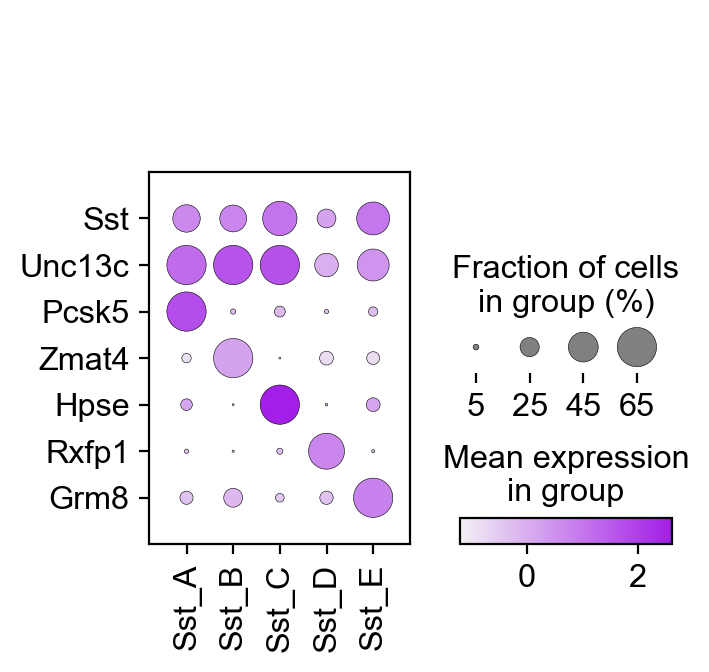

In [14]:
sc.pl.dotplot(sst, ['Sst', 'Unc13c',
                   'Pcsk5', 
                    'Zmat4',
                   'Hpse', 
                   'Rxfp1',
                   'Grm8',], 
              groupby='Type',swap_axes=True, use_raw=False, dot_min=0,dot_max=0.65,
              cmap=mapcol,
              save='Sst_type_markersS6.pdf')

In [15]:
vip = gaba_all[gaba_all.obs.Subclass=='Vip',:]

In [40]:
for i in ['Vip_A', 'Vip_B', 'Vip_C']:
    print(DE(adata=vip, obs_id='Type', 
             obs_id_test = i, ref='rest')[0:10].index)

Trying to set attribute `.obs` of view, copying.
... storing 'leiden' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Age' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Type' as categorical


Index(['Creb5', 'Vwc2', 'Rspo2', 'Pkp2', 'Chat', 'Ostf1', 'Has2os', 'Gpc6',
       'Plce1', 'Slc5a7'],
      dtype='object')
Index(['Zbtb20', 'Sntb1', 'Rxfp1', 'Bcar3', 'Kctd16', 'Pcdh11x', 'Deptor',
       'St6galnac5', 'Pbx3', 'Arhgef28'],
      dtype='object')
Index(['Itih5', '5033421B08Rik', 'Plekha2', 'Mybpc1', 'Kirrel3', 'Rai14',
       'Col15a1', 'Plxdc1', 'Tmem132d', 'Itga4'],
      dtype='object')


Trying to set attribute `.obs` of view, copying.
... storing 'leiden' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Age' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Type' as categorical


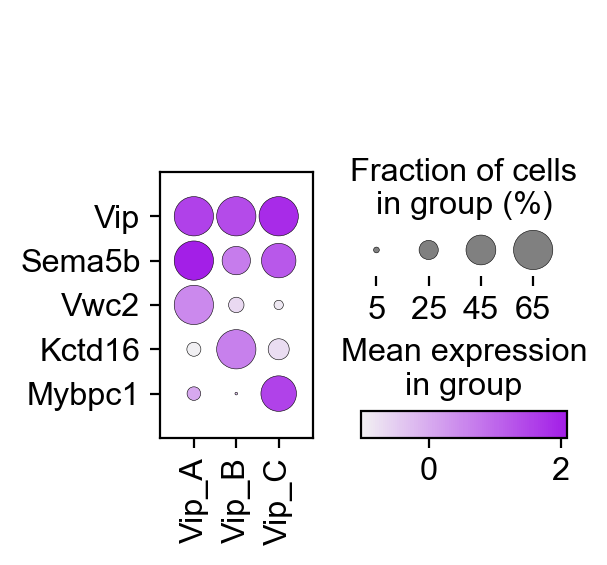

In [16]:
sc.pl.dotplot(vip, ['Vip', 'Sema5b',
                   'Vwc2', 
                   'Kctd16',
                   'Mybpc1', ], 
              groupby='Type',swap_axes=True, use_raw=False, dot_min=0,dot_max=0.65,
              cmap=mapcol,
              save='Vip_type_markersS6.pdf')

In [80]:
others = gaba_all[gaba_all.obs.Subclass=='Lamp5',:].concatenate(gaba_all[gaba_all.obs.Subclass=='Stac',:],
                                                               gaba_all[gaba_all.obs.Subclass=='Frem1',:])

In [81]:
pd.Categorical(others.obs.Type.values)

['Lamp5', 'Lamp5', 'Lamp5', 'Lamp5', 'Lamp5', ..., 'Frem1', 'Frem1', 'Frem1', 'Frem1', 'Frem1']
Length: 2299
Categories (3, object): ['Frem1', 'Lamp5', 'Stac']

In [52]:
others = others[others.obs.Type!='Lamp5',:]

In [53]:
for i in ['Lamp5_A', 'Lamp5_B', 'Frem1', 'Stac']:
    print(DE(adata=others, obs_id='Type', 
             obs_id_test = i, ref='rest')[0:10].index)

Trying to set attribute `.obs` of view, copying.
... storing 'leiden' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Subclass' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Age' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Type' as categorical


Index(['Htr1f', 'Nxph1', 'Chst7', 'Sv2c', 'Sema5a', 'Unc5d', 'Kirrel', 'Alk',
       'Unc5c', 'Hcrtr2'],
      dtype='object')
Index(['Ndnf', 'Gm30835', 'Ntn1', 'Reln', 'Ndst4', 'Zfp804b', 'Sema3e',
       'Gm4128', 'Ltbp1', 'Grik1'],
      dtype='object')
Index(['Htr3a', 'Galnt18', 'Trp53i11', 'Slc44a5', 'Smoc1', 'Adamts16', 'Dpf3',
       'Yjefn3', 'Dysf', 'Whrn'],
      dtype='object')
Index(['D030055H07Rik', 'A830012C17Rik', 'Penk', 'Calb2', 'Grin3a', 'Grm8',
       'Prr16', 'Prss12', 'Stac', 'Crh'],
      dtype='object')


# DR/DL ARI barplot

In [6]:
P28_DR = np.load(path+'ARI_P28_DR.npy')

P38_DR = np.load(path+'ARI_P38_DR.npy')[0:3]

P28_DL = np.load(path+'ARI_P28_DL.npy')

In [7]:
P38_DR[2]

0.6021621261495468

In [8]:
df = pd.DataFrame({
    'Subclass': [ 'Pvalb', 'Pvalb', 'Pvalb', 
                   'Sst', 'Sst', 'Sst',
                   'Vip', 'Vip', 'Vip',],
    'Mapping': ['P28_DR', 'P38_DR', 'P28_DL',
                'P28_DR', 'P38_DR', 'P28_DL',
                 'P28_DR', 'P38_DR', 'P28_DL',],
    'ARI': [P28_DR[0], P38_DR[0], P28_DL[0],
           P28_DR[1], P38_DR[1], P28_DL[1],
           P28_DR[2], P38_DR[2], P28_DL[2]]})

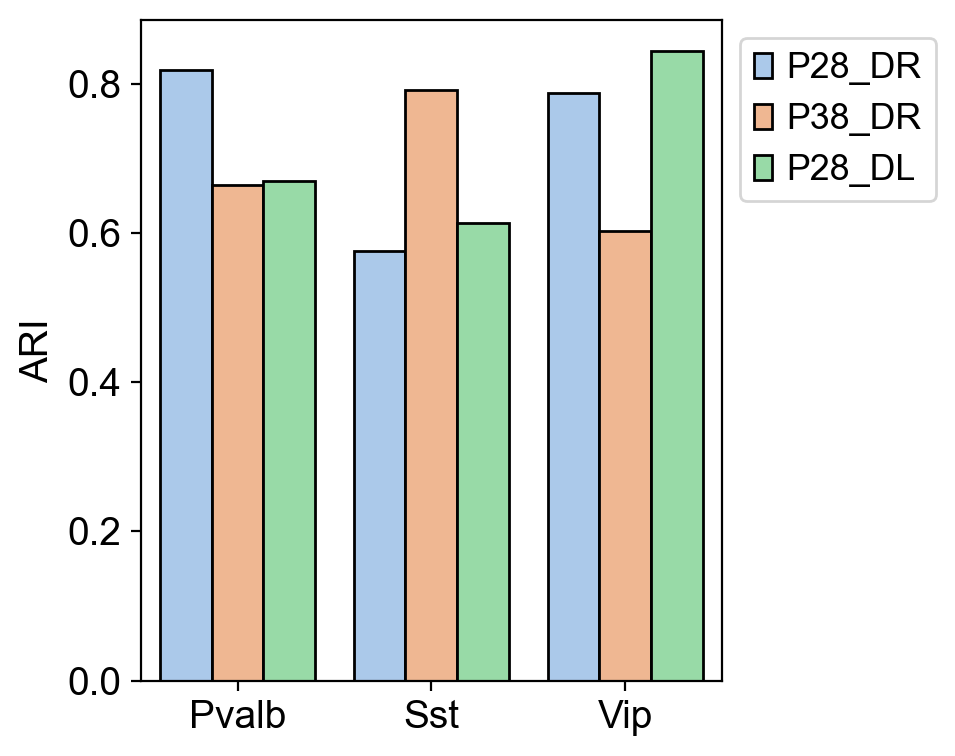

In [9]:
plt.figure(figsize=(5,4))
sns.barplot(x='Subclass', y='ARI', hue='Mapping', 
            data=df, edgecolor="black", linewidth=1,palette='pastel')
plt.legend(fontsize=12)
plt.grid(False)
plt.xlabel('')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel(ylabel = 'ARI', fontsize=14)
plt.legend(bbox_to_anchor=(1, 1))

plt.tight_layout()

plt.savefig('ActivityARIs_gaba.pdf')

# Tuning cluster resolution

## Prep

In [125]:
for i in processed_objs:
    sc.pp.neighbors(i, n_neighbors=25, use_rep='X_harmony')
    sc.tl.leiden(i)
    sc.tl.umap(i)

## Compute and plot

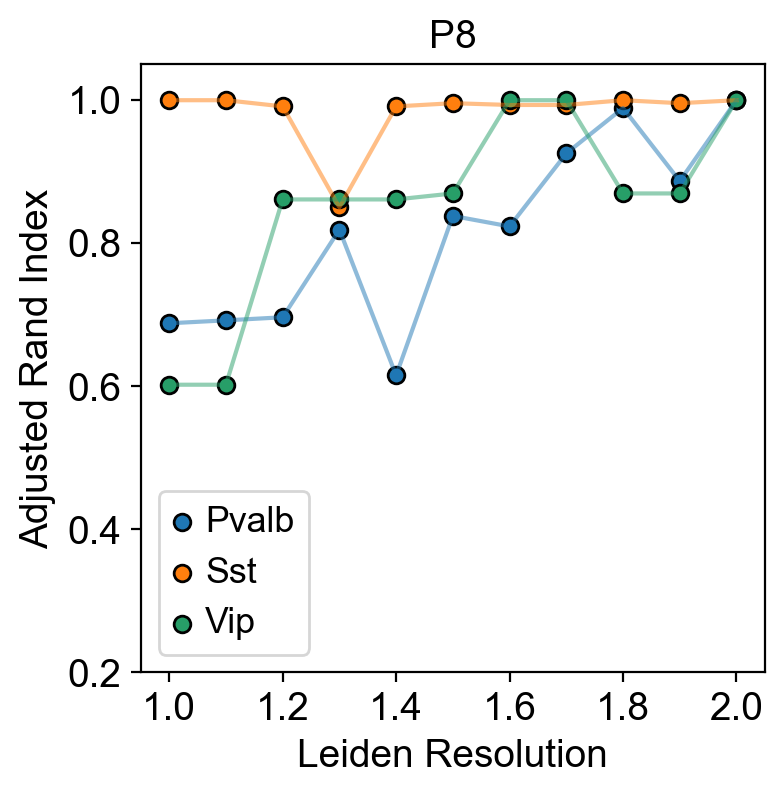

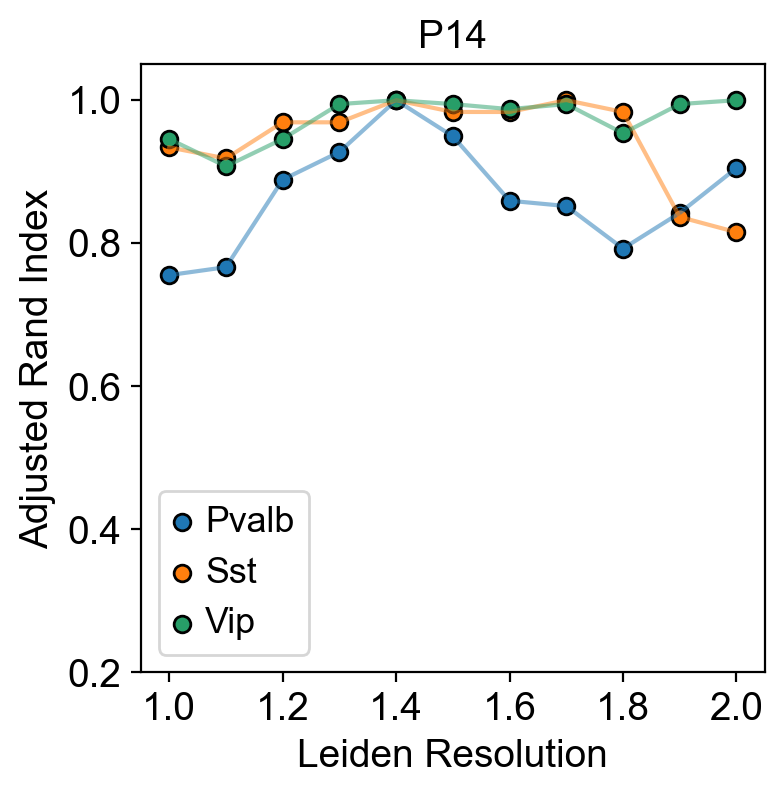

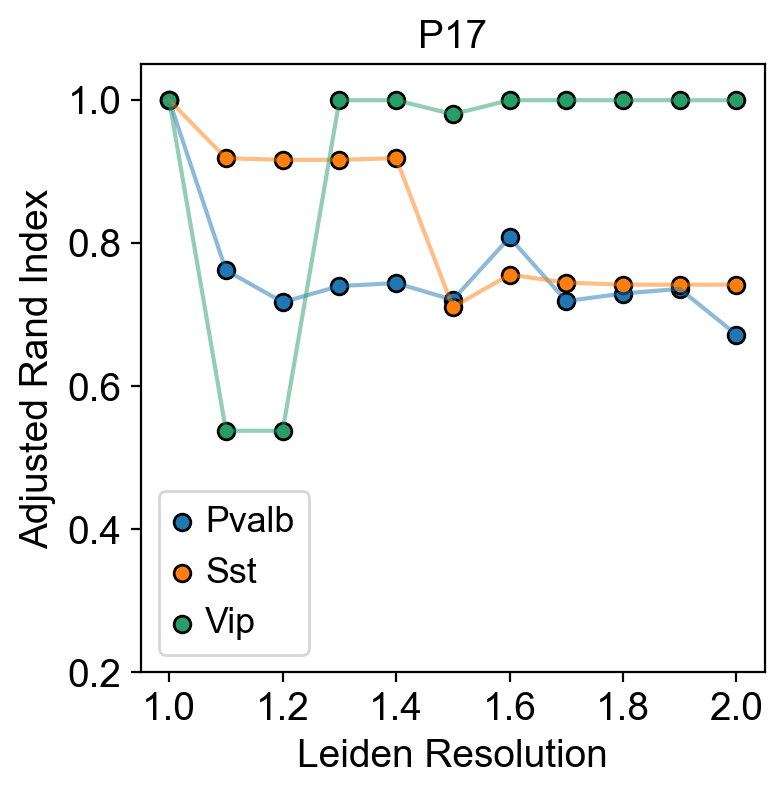

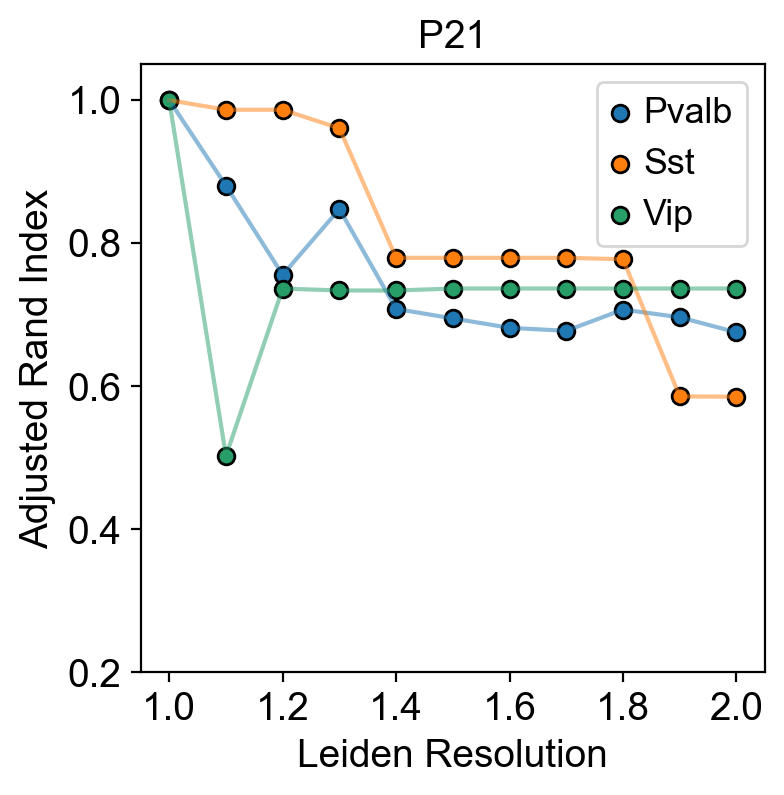

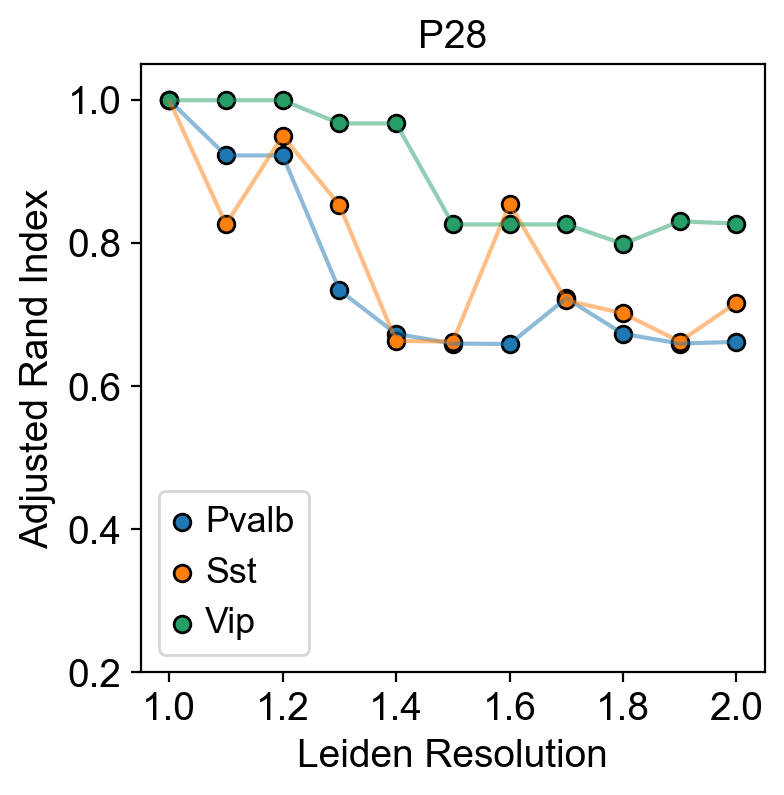

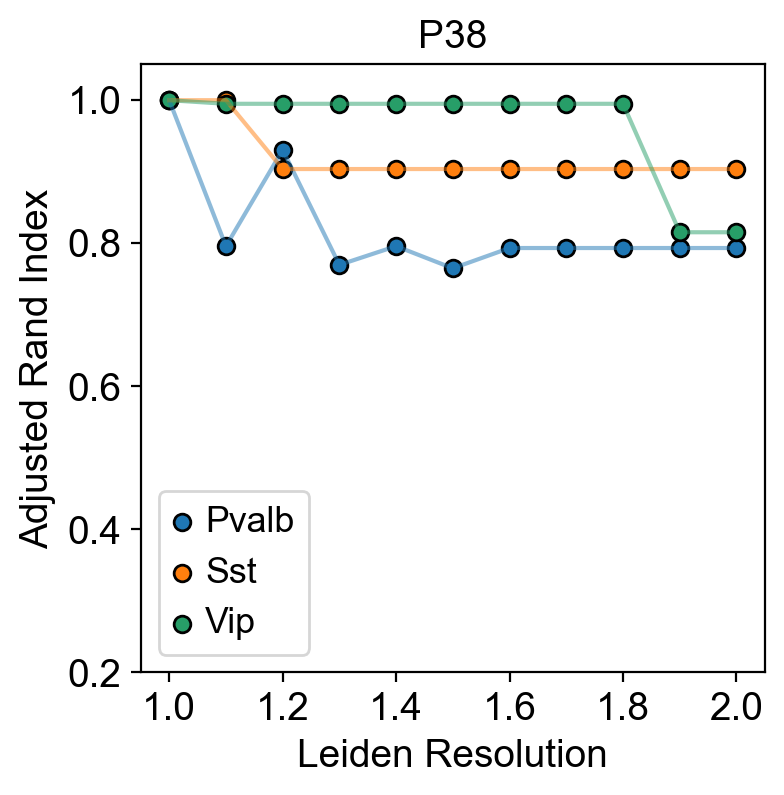

In [149]:
x = np.arange(1,2.1, 0.1)
ARIs_master = []

for obj in processed_objs:
    adata = obj

    def_res_leiden_PV = (list(adata[adata.obs.Subclass=='Pvalb',:].obs.leiden.values))
    def_res_leiden_SST = (list(adata[adata.obs.Subclass=='Sst',:].obs.leiden.values))

    def_res_leiden_VIP = (list(adata[adata.obs.Subclass=='Vip',:].obs.leiden.values))

    ARI_PV = []
    ARI_SST = []

    ARI_VIP = []


    for res in x:
        sc.tl.leiden(adata, resolution=res)
        #fig, axs = plt.subplots(1, 3, figsize = (13.5,4), constrained_layout=True)
        #sc.pl.umap(adata, color='Type', legend_fontsize='10', ax=axs[0], 
        #           show=False, title=adata.obs.Age[0]+ ' : ' + str(adata.shape[0]) + ' cells', frameon=True, legend_loc='on data')
        #sc.pl.umap(adata, color='leiden', ax=axs[1], show=False, title= adata.obs.Age[0]+' Leiden: ' + str(res) + ' res', legend_loc='on data')
        #sc.pl.umap(adata, color='sample', ax=axs[2], show=False, title=adata.obs.Age[0]+' : ' + str(adata.shape[0]) + ' cells')
        ARI_PV.append(adjusted_rand_score(def_res_leiden_PV, (list(adata[adata.obs.Subclass=='Pvalb',:].obs.leiden.values))))
        ARI_SST.append(adjusted_rand_score(def_res_leiden_SST, (list(adata[adata.obs.Subclass=='Sst',:].obs.leiden.values))))

        ARI_VIP.append(adjusted_rand_score(def_res_leiden_VIP, (list(adata[adata.obs.Subclass=='Vip',:].obs.leiden.values))))
    plt.show()
    plt.plot(x, ARI_PV, alpha=0.5)
    plt.scatter(x, ARI_PV, label='Pvalb', edgecolor='black')

    plt.plot(x, ARI_SST, alpha=0.5)
    plt.scatter(x, ARI_SST, label='Sst', edgecolor='black')

    plt.plot(x, ARI_VIP, alpha=0.5)
    plt.scatter(x, ARI_VIP, label='Vip', edgecolor='black' )


    plt.legend()
    plt.grid(False)
    plt.xlabel('Leiden Resolution')
    plt.ylabel('Adjusted Rand Index')
    plt.xticks(np.arange(1,2.1, 0.2))
    plt.ylim([0.2, 1.05])
    plt.title(adata.obs.Age[0])
    plt.show()

    
    ARIs_df = pd.DataFrame(np.transpose(np.array([ARI_PV, ARI_SST, ARI_VIP])), 
                  columns=['Pvalb', 'Sst', 'Vip'])
    ARIs_df['res'] = np.arange(1,2.1, 0.1)
    
    ARIs_master.append(ARIs_df)



In [150]:
reses = list(np.arange(1,2.1,0.1)) + list(np.arange(1,2.1,0.1))+list(np.arange(1,2.1,0.1))+list(np.arange(1,2.1,0.1))+list(np.arange(1,2.1,0.1))+list(np.arange(1,2.1,0.1))
reses_ = np.array(np.round(np.array(reses), 3), dtype='str')

ARI_all = pd.concat(ARIs_master)

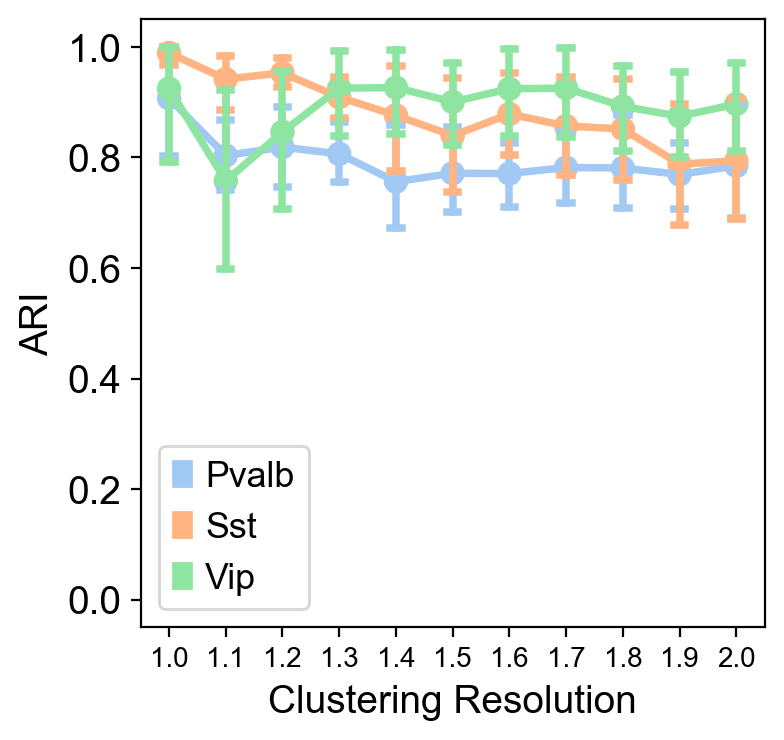

In [182]:
palette = sns.color_palette('pastel').as_hex()[0:6]

sns.pointplot(reses_, y="Pvalb", data=ARI_all,capsize=.2, color=palette[0], label='Pvalb')
sns.pointplot(reses_, y="Sst", data=ARI_all,capsize=.2, color=palette[1], label='Sst')
sns.pointplot(reses_, y="Vip", data=ARI_all,capsize=.2, color=palette[2], label='Vip')


plt.grid(False)
plt.ylabel('ARI')
plt.xlabel('Clustering Resolution')
plt.ylim([-0.05,1.05])

import matplotlib.patches as mpatches
pv_patch = mpatches.Patch(color=palette[0], label='Pvalb')
sst_patch = mpatches.Patch(color=palette[1], label='Sst')
vip_patch = mpatches.Patch(color=palette[2], label='Vip')

plt.legend(handles=[pv_patch, sst_patch, vip_patch])

plt.xticks(fontsize=10)

plt.savefig('ClustRes_gaba.pdf')


In [ ]:
ARI_all.to_excel('ARIs_gaba.xlsx')